# DEAP 的基本使用

本文简单介绍DEAP的基本框架，并结合一个实例展示使用DEAP中算法的过程。

参考资料如下：

- [DEAP: Evolutionary Algorithms Made Easy](https://www.jmlr.org/papers/volume13/fortin12a/fortin12a.pdf)
- [DEAP documentation](https://deap.readthedocs.io/en/master/)
- [基于DEAP库的Python进化算法从入门到入土](https://www.jianshu.com/p/8fa044ed9267)
- [lmarti/evolutionary-computation-course](https://github.com/lmarti/evolutionary-computation-course)

安装deap执行以下语句即可：

```Shell
conda install -c conda-forge deap
```

## DEAP 核心结构

进化算法(Evolutionary Algorithms)是一类元启发式算法的统称。这类算法借鉴大自然中生物的进化、选择与淘汰机制，通常先产生一个族群，然后不断进化与淘汰，最终产生能够在严酷的自然环境中生存的优异个体（也就是有较大适应度函数的可行解）。它具有自组织、自适应的特性，常被用来处理传统优化算法难以解决的问题。

其优点在于：

- 泛用性强，对连续变量和离散变量都能适用；
- 不需要导数信息，因此不要求适应度函数的连续和可微性质(或者说不需要问题内在机理的相关信息)；
- 可以在解空间内大范围并行搜索；
- 不容易陷入局部最优；
- 高度并行化，并且容易与其他优化方法整合。

缺点包括：

- 对于凸优化问题，相对基于梯度的优化方法（例如梯度下降法，牛顿/拟牛顿法）收敛速度更慢；
- 进化算法需要在搜索空间投放大量个体来搜索最优解。对于高维问题，由于搜索空间随维度指数级膨胀，需要投放的个体数也大幅增长，会导致收敛速度变慢；
- 设计编码方式、适应度函数以及变异规则需要大量经验。

宽泛来讲，大部分进化算法都具有以下元素：

- 个体编码(Individual representation): 将问题的解空间编码映射到搜索空间的过程。常用的编码方式有二值编码(Binary)，格雷编码(Gray)，浮点编码(Floating-point)等。
- 评价(Evaluation and Fitness assignment): 设定一定的准则评价族群内每个个体的优秀程度。这种优秀程度通常称为适应度(Fitness)。
- 配种选择(Mating selection): 建立准则从父代中选择个体参与育种。尽可能选择精英个体的同时也应当维护种群的多样性，避免算法过早陷入局部最优。
- 变异(Variation): 变异过程包括一系列受到生物启发的操作，例如重组(Recombination)，突变(mutation)等。通过变异操作，父代的个体编码以一定方式继承和重新组合后，形成后代族群。
- 环境选择(Environmental selection): 将父代与子代重组成新的族群。这个过程中育种得到的后代被重新插入到父代种群中，替换父代种群的部分或全体，形成具有与前代相近规模的新族群。
- 停止准则(Stopping crieterion): 确定算法何时停止，通常有两种情况：算法已经找到最优解或者算法已经选入局部最优，不能继续在解空间内搜索。

利用这些元素，我们就可以依照流程图组成一个进化算法：

![](pictures/17867674-a70e9d4134cdbad6.webp)

伪代码表述如下：

``` pseudo-code
Generate the initial population P(0) at random, and set t to 0.
repeat
    Evaluate the fitness of each individual in P(t).
    Select parents from P(t) based on their fitness.
    Obtain population P(t+1) by making variations to parents.
    Set t = t + 1
until Stopping crieterion satisfied
```

python代码会类似这样：

```python
def evolutionary_algorithm():
    'Pseudocode of an evolutionary algorithm'    
    populations = [] # a list with all the populations
    
    populations[0] =  initialize_population(pop_size)
    t = 0
    
    while not stop_criterion(populations[t]):
        fitnesses = evaluate(populations[t])
        offspring = matting_and_variation(populations[t],
                                          fitnesses)
        populations[t+1] = environmental_selection(           
                                          populations[t],
                                          offspring)
        t = t+1
```

进化算法已经发展成为一个由许多不同的技术和机制组成的复杂领域了，为了能够更快速的构建算法原型，Fortin等制作了DEAP这一工具。

DEAP核心主要由两个结构组成：creator和toolbox。creator模块是一个meta-factory（关于元编程的概念可以参考[这里](https://github.com/waterDLut/hydrus/blob/master/1-learn-python/5.1-advanced-python.ipynb)“元编程”一小节，还是有必要了解一下的，否则后面的代码不好理解），能够在运行时通过继承和组合来构建类。数据和函数能够动态地添加到已有的类中以根据用户定制的函数创建新的类型。creator的概念是灵活实现各类进化算法的关键。toolbox是各类工具的容器，它由使用者选择自己要用的工具来填充，选择一个工具后将它注册到toolbox中，每类工具有它的那一类运算名字，比如交叉操作，叫“mate”。

这两个核心模块会被一些外围模块运用。algorithms模块包含了很多经典的进化算法，用户可以从这里开始使用代码。tools模块提供了进化基本运算，比如初始化、变异、交叉、选择等，它们都能直接添加入toolbox以使用算法；tools还有一些整合进化中相关信息的组件，比如最优种群的适应度统计、谱系、名人堂等，以及保存中间结果等。base模块有一些基本的进化算法中常用数据结构，不过不是python实现的。最后一个模块dtm，是为了执行分布式任务。

接下来介绍上面涉及到的中间过程。

## 定义个体

- 单目标优化：creator.create('FitnessMin', base.Fitness, weights=(-1.0, ))

在创建单目标优化问题时，weights用来指示最大化和最小化。此处-1.0即代表问题是一个最小化问题，对于最大化，应将weights改为正数，如1.0。

另外即使是单目标优化，weights也需要是一个tuple，以保证单目标和多目标优化时数据结构的统一。

对于单目标优化问题，weights 的绝对值没有意义，只要符号选择正确即可。

- 多目标优化：creator.create('FitnessMulti', base.Fitness, weights=(-1.0, 1.0))

对于多目标优化问题，weights用来指示多个优化目标之间的相对重要程度以及最大化最小化。如示例中给出的(-1.0, 1.0)代表对第一个目标函数取最小值，对第二个目标函数取最大值。

创建类型后，需要用值填充它们，值的形式有多种。比如实数编码(Value encoding)：直接用实数对变量进行编码。优点是不用解码，基因表达非常简洁，而且能对应连续区间。但是实数编码后搜索区间连续，因此容易陷入局部最优。

具体执行时，使用 Toolbox。用random.random来产生随机数，给到5个实数编码的个体。

注册函数register第一个参数就是一个别名，第二个参数就是这个别名对应的实际的函数，剩余的参数就是别名被调用的时候传给这个函数的参数。

In [1]:
import random

from deap import base
from deap import creator
from deap import tools

In [2]:
IND_SIZE = 5

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox1 = base.Toolbox()
toolbox1.register("attr_float", random.random)
toolbox1.register("individual", tools.initRepeat, creator.Individual,
                 toolbox1.attr_float, n=IND_SIZE)

In [4]:
ind1 = toolbox1.individual()

In [5]:
print(ind1)

[0.303294697772998, 0.32927165578090345, 0.11870912399752243, 0.15879442449763292, 0.5896414824088129]


可以看看它的适应度。个体被打印为它的基类表示（这里是一个列表）并且适应度是valid的，因为现在它不包含任何值。

In [6]:
print(ind1.fitness.valid)

False


## 评价

评价部分是根据任务的特性高度定制的，DEAP库中并没有预置的评价函数模版。这里也是针对自己的问题用户自己写相关代码的地方。比如这里还是用一个很简单的例子，求个体元素的和。

在使用DEAP时，需要注意的是，无论是单目标还是多目标优化，评价函数的返回值必须是一个tuple类型。

适应度是浮点数值，有一个属性valid来帮助了解个体是否需要被再评价

In [7]:
def evaluate(individual):
    # Do some hard computing on the individual
    a = sum(individual)
    b = len(individual)
    return a, 1. / b

In [8]:
ind1.fitness.values = evaluate(ind1)

In [9]:
print(ind1.fitness.valid)

True


In [10]:
print(ind1.fitness)

(1.4997113844578696, 0.2)


## 变异

变异过程就是从父代的基因出发，进行操作，最终得到子代基因的过程。通常包括交叉(Crossover)和突变(Mutation)两种操作。

### 突变

deap.tools 模块中有多种变异算子。

|函数|简介|适用编码方式|
|-|-|-|
|mutGaussian()|高斯突变|实数|
|mutShuffleIndexes()|乱序突变|实数、二进制、序列|
|mutFlipBit()|位翻转突变|二进制|
|mutPolynomialBounded()|有界多项式突变|实数|
|mutUniformInt()|均匀整数突变|实数、序列|
|mutESLogNormal()||
    

每个突变都有自己的特点，可能适用于不同类型的个体。请仔细阅读所选运算的文档，以避免出现不良行为。

这里例子是高斯突变：tools.mutGaussian(individual, mu, sigma, indpb) 

对个体序列中的每一个基因按概率变异，变异后的值为按均值为mu，方差为sigma的高斯分布选取的一个随机数。如果不希望均值发生变化，则应该将设为0。

变异算子的规则是它们只负责变异，这意味着如果原始个体必须保留或引用其他个体（参见后面的选择算子），则必须在变异个体之前制作独立副本。

In [11]:
mutant = toolbox1.clone(ind1)
ind2, = tools.mutGaussian(mutant, mu=0.0, sigma=0.2, indpb=0.2)
del mutant.fitness.values

删除适应度的值是因为它们不再与个体相关。如上所述，突变确实会发生变异，并且只会使个体发生变异，它不负责使适合度或其他任何事情无效。下面说明ind2和mutant实际上是同一个个体。

In [12]:
ind2 is mutant

True

In [13]:
mutant is ind2

True

### 交叉

DEAP内置的交叉(Crossover)操作

|函数|	简介|	适用编码方式|
|-|-|-|
|cxOnePoint()|	单点交叉|	实数、二进制|
|cxTwoPoint()|	两点交叉|	实数、二进制|
|cxUniform()|	均匀交叉|	实数、二进制|
|cxPartialyMatched()|	部分匹配交叉PMX|	序列|
|cxUniformPartialyMatched()|	PMX变种，改两点为均匀交叉|	序列|
|cxOrdered()|	有序交叉|	序列|
|cxBlend()|	混合交叉|	实数|
|cxESBlend()|	带进化策略的混合交叉	||
|cxESTwoPoint()|	带进化策略的两点交叉|	|
|cxSimulatedBinary()|	模拟二值交叉|	实数|
|cxSimulatedBinaryBounded()|	有界模拟二值交叉|	实数|
|cxMessyOnePoint()|	混乱单点交叉|	实数、二进制|

比如单点交叉：deap.tools.cxOnePoint(ind1, ind2)

最简单的交叉方式，选择一个切口，将两条基因切开之后，交换尾部基因段。该方法非常简单，但是多篇文章指出，该算法在各种实验中性能都被其他交叉算法吊打，因此算是一种不建议使用的loser algorithm。

两点交叉：deap.tools.cxTwoPoint(ind1, ind2)

用两个点切开基因之后，交换切出来的基因段。

![](pictures/17867674-b08f2a38bd9540c7.webp)

比如均匀交叉：deap.tools.cxUniform(ind1, ind2, indpb)

指定一个变异几率，两父代中的每个基因都以该几率交叉。

![](pictures/17867674-61e22658b6147854.webp)

官方提示最好不要直接用父代进行交叉，因为有些交叉算法是in-place运算的，因此最好先复制，再进行交叉。具体见代码：

In [14]:
child1, child2 = [toolbox1.clone(ind) for ind in (ind1, ind2)]
tools.cxBlend(child1, child2, 0.5)
del child1.fitness.values
del child2.fitness.values

## 选择

DEAP的tools模块中内置了13种选择操作，对全部选择算子的描述可以参考[官方文档](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament)。

|函数|	简介|
|-|-|
|selTournament()|	锦标赛选择|
|selRoulette()|	轮盘赌选择（不能用于最小化或者适应度会小于等于0的问题）|
|selNSGA2()|	NSGA-II选择，适用于多目标遗传算法|
|selSPEA2()|	SPEA2选择，目前版本(ver 1.2.2)的该函数实现有误，没有为个体分配距离，不建议使用。|
|selRandom()|	有放回的随机选择|
|selBest()|	选择最佳|
|selWorst()|	选择最差|
|selTournamentDCD()|	Dominance/Crowding distance锦标赛选择，目前版本的实现也有些问题|
|selDoubleTournament()|	Size+Fitness双锦标赛选择|
|selStochasticUniversalSampling()|	随机抽样选择|
|selLexicase()|	词典选择|
|selEpsilonLexicase()|	词典选择在连续值域上的扩展|
|selAutomaticEpsilonLexicase()|	|

比如锦标赛选择：deap.tools.selTournament(individuals, k, tournsize, fit_attr = 'fitness')

就是模拟锦标赛的方式，首先在族群中随机抽取tournsize个个体，然后从中选取具有最佳适应度的个体，将此过程重复k次，获得育种族群。tournsize越大，选择强度(selection intensity)越高，在选择之后留下的育种族群的平均适应度也就越高。

下图给出了由5个个体构成的族群中进行一次tournsize为3的锦标赛选择的过程。

![](pictures/17867674-d94652a0f18353b2.webp)

还有轮盘赌选择，它是最常见的选择策略，可以看作是有放回的随机抽样。

轮盘赌选择: deap.tools.selRoulette(individuals, k, fit_attr = 'fitness')

在轮盘赌选择中，每个个体$a_i$被选中的概率$P(a_i)$与其适应度函数$f(a_i)$成正比：

$$P(a_i)=\frac{f(a_i)}{\sum _{i} f(a_i)}$$

下图给出了与前文同样例子的轮盘赌选择

![](pictures/17867674-3c503fc666584cf5.webp)

但在实际应用中，很多文章都指出轮盘赌选择的性能较差，在通常情况下都不如随机抽样选择和锦标赛选择。

随机普遍抽样选择：deap.tools.selStochasticUniversalSampling(individuals, k, fit_attr = 'fitness')

随机普遍抽样选择是一种有多个指针的轮盘赌选择，其优点是能够保存族群多样性，而不会像轮盘赌一样，有较大几率对重复选择最优个体。

在与前文相同的例子中使用随机普遍抽样选择，设定指针数k为3，那么指针间距即为1/3

![](pictures/17867674-c20b83385c700292.webp)

In [15]:
selected = tools.selBest([child1, child2], 2)
child1 in selected

True

## One Max 问题示例

下面给一个完整点的例子，后续会在此例子上涉及到更多细节。

* 最大化二进制字符串（列表、向量等）中 1 的数量。
* 更正式地说，从长度为 $n$ 的二进制字符串集合中，
$$\mathcal{S}=\left\{s_1,\ldots,s_n\right\}, \text{ with } s_i=\left\{0,1\right\}.$$
* 找到 $s^\ast\in\mathcal{S}$ 使得
$$s^\ast = \operatorname*{arg\,max}_{s\in\mathcal{S}} \sum_{i=1}^{n}{s_i}.$$
* 很明显，最优值是一个 *all-ones* 字符串。

首先定义问题

In [16]:
import random
from deap import algorithms, base, creator, tools

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [18]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\hust2\miniconda3\envs\hydrus\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [19]:
def evalOneMax(individual):
    return (sum(individual),)

然后定义元素

In [20]:
toolbox = base.Toolbox()

In [21]:
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [22]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

然后运行实验：

In [23]:
pop = toolbox.population(n=300)

Lets run only 10 generations

In [24]:
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, 
                             ngen=10, verbose=False)

In [25]:
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

Current best fitness: (82,)


In [26]:
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, 
                             ngen=50, verbose=False)

In [27]:
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

Current best fitness: (100,)


## Tool Decoration

在实际应用中，有时候需要对代码内部做一些精准控制，这时候工具装饰器Tool Decoration是很有用的，并且它很强大，使用它无需更改算法或运算符中的任何内容。

装饰器是一个被调用的包装器，而不是一个函数。它被要求在调用实际函数之前和之后进行一些初始化和终止工作。

例如，需要约束域时，可以将装饰器应用于变异和交叉，以防止任何个体越界。

下面是例子，定义了一个装饰器，用于检查列表中的任何属性是否越界，如果是，则对其进行切割。

- 装饰器使用三个函数定义，以接收 min 和 max 参数。
- 每当调用突变或交叉时，都会检查结果个体的边界。

In [30]:
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in xrange(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator

toolbox.register("mate_example", tools.cxBlend, alpha=0.2)
toolbox.register("mutate_example", tools.mutGaussian, mu=0, sigma=2)

MIN = 0; MAX = 10

toolbox.decorate("mate_example", checkBounds(MIN, MAX))
toolbox.decorate("mutate_example", checkBounds(MIN, MAX))

这会作用于交叉和变异，因为两者都返回一组个体。变异通常被认为是返回单个个体，但跟评估一样，单个个体案例是多个个体案例的特例。

## Variations

变体允许使用预定义的小的组块构建简单的算法。

为了使用变体，必须将工具箱设置为包含所需的运算符。

例如，在之前提出的算法中，将交叉和变异重新组合在 varAnd() 函数中，该函数需要工具箱包含 mate() 和 mutate() 函数。这些变化可用于简化算法的编写，如下所示

In [31]:
from deap import algorithms

NGEN = 20 # number of generations
CXPB = 0.6
MUTPB = 0.05

for g in range(NGEN):
    # Select and clone the next generation individuals
    offspring = map(toolbox.clone, toolbox.select(pop, len(pop)))

    # Apply crossover and mutation on the offspring
    offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring

## Algorithms

算法模块中实现了多种算法。它们非常简单，反映了各类文献中存在的进化算法的基本类型。

为了设置算法的工具箱，必须在指定的名称下注册所需的运算符。

一旦工具箱准备好，就可以启动算法了。

simple evolutionary algorithm 需要 5 个参数：种群、工具箱、每一代每个个体交配的概率 (cxpb)、每一代每个个体变异的概率 (mutpb) 和要完成的代数 (ngen)。

In [32]:
from deap import algorithms

result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50)

gen	nevals
0  	0     
1  	174   
2  	173   
3  	159   
4  	193   
5  	191   
6  	202   
7  	179   
8  	178   
9  	185   
10 	181   
11 	187   
12 	210   
13 	170   
14 	164   
15 	179   
16 	179   
17 	180   
18 	189   
19 	159   
20 	165   
21 	159   
22 	182   
23 	171   
24 	197   
25 	171   
26 	187   
27 	178   
28 	186   
29 	166   
30 	183   
31 	164   
32 	195   
33 	181   
34 	188   
35 	184   
36 	174   
37 	184   
38 	194   
39 	188   
40 	172   
41 	188   
42 	184   
43 	166   
44 	174   
45 	200   
46 	176   
47 	193   
48 	172   
49 	205   
50 	180   


## Computing Statistics

通常，人们想要对优化中发生的事情进行统计。工具中的Statistics能够编译任何指定对象的任意属性的此类数据。需要使用与工具箱完全相同的语法在 stats 对象内注册所需的统计函数。

In [33]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

统计对象是使用键作为第一个参数创建的。必须为该键提供一个函数，该函数稍后将应用于计算统计数据的数据。前面的代码示例使用每个元素的 fitness.values 属性。

In [34]:
import numpy
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

统计函数现已注册。

register 函数需要一个别名作为第一个参数，一个对向量进行操作的函数作为第二个参数。
任何后续参数在调用时都会传递给函数。统计对象的创建现已完成。

当使用预定义的算法时，例如 eaSimple()、eaMuPlusLambda()、eaMuCommaLambda() 或 eaGenerateUpdate()，之前创建的统计对象可以作为算法的参数提供。

In [35]:
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=0, 
                                   stats=stats, verbose=True)

gen	nevals	avg    	std    	min	max
0  	0     	99.1633	2.07284	87 	100


将自动计算每一代种群的统计数据。

verbose 参数在优化发生时在屏幕上打印统计信息。

算法返回后，将返回最终种群和日志。

在编写自己的算法时，包括统计数据非常简单。只需要编译所需对象的统计信息。

例如，通过调用 compile() 方法来编译给定种群的统计数据。

In [36]:
record = stats.compile(pop)

compile 函数的参数必须是将调用键的元素的可迭代对象。在这里，种群 (pop) 包含个体。

统计对象将调用每个人的 key 函数来检索他们的 fitness.values 属性。

最终得到的值数组被赋予每个统计函数，并将结果放入与该函数关联的键下的记录字典中。

打印记录揭示了它的性质。

In [37]:
print(record)

{'avg': 99.16333333333333, 'std': 2.0728375613046857, 'min': 87.0, 'max': 100.0}


## 记录数据

一旦统计产生数据，就可以将其保存在日志中以供进一步使用。

日志旨在成为按时间顺序排列的条目（作为字典）。

它直接符合统计对象返回的数据类型，但不限于此数据。

事实上，任何东西都可以纳入日志的条目中。

In [38]:
logbook = tools.Logbook()
logbook.record(gen=0, evals=30, **record)

record() 方法采用可变数量的参数，每个参数都是要记录的数据。在最后一个示例中，我们使用 star 魔法保存统计对象生成的记录中包含的生成、评估次数和所有内容。所有记录都将保存在日志中，直至销毁。

在多次记录之后，人们可能想要检索日志中包含的信息。

In [39]:
gen, avg = logbook.select("gen", "avg")

select() 方法提供了一种在所有记录中检索与关键字关联的所有信息的方法。此方法采用可变数量的字符串参数，这些参数是记录或统计对象中使用的关键字。在这里，我们使用一次 select 调用来检索生成和平均适应度。

## 打印到屏幕

日志可以打印到屏幕或文件。

它的 \_\_str\_\_() 方法返回第一个记录中插入的每个键的标头以及每个键的完整日志。

行按插入的时间顺序排列，而列按未定义的顺序排列。

指定顺序的最简单方法是将 header 属性设置为指定列顺序的字符串列表。

In [40]:
logbook.header = "gen", "avg", "spam"

In [41]:
print(logbook)

gen	avg    	spam
0  	99.1633	    


## 绘图功能

优化完成后最常见的操作之一是在演化过程中绘制数据。

日志允许非常有效地做到这一点。

使用 select 方法，可以检索所需的数据并使用 matplotlib 绘制它。

In [42]:
pop = toolbox.population(n=300)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, 
                                   stats=stats, verbose=False)

In [43]:
gen = logbook.select("gen")
fit_mins = logbook.select("min")
size_avgs = logbook.select("avg")

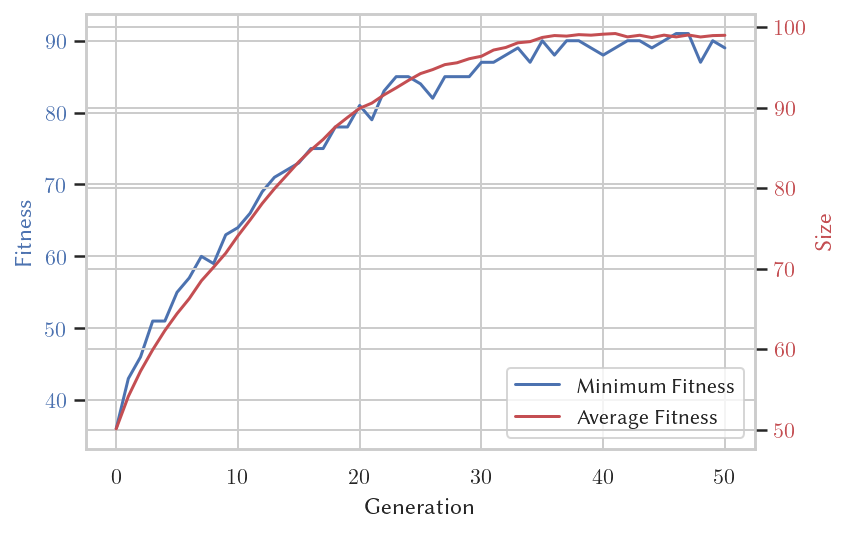

In [44]:
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower right", frameon=True)

plt.show()

## 约束处理

我们已经看到了一些替代方案。

当落入给定区域时，惩罚函数是处理个人无法评估或因问题特定原因被禁止的最基本方法。

惩罚函数根据解决方案中违反约束的数量为这些个体提供适应度劣势。

<img src='http://deap.readthedocs.org/en/master/_images/constraints.png' width='92%'/>

在 DEAP 中，可以使用工具模块中提供的 DeltaPenality 装饰器将惩罚函数添加到任何评估函数中。

In [45]:
from math import sin
from deap import base
from deap import tools

def evalFct(individual):
    """Evaluation function for the individual."""
    x = individual[0]
    return (x - 5)**2 * sin(x) * (x/3),

def feasible(individual):
    """Feasability function for the individual. Returns True if feasible False
    otherwise."""
    if 3 < individual[0] < 5:
        return True
    return False

def distance(individual):
    """A distance function to the feasability region."""
    return (individual[0] - 5.0)**2

toolbox = base.Toolbox()
toolbox.register("evaluate", evalFct)
toolbox.decorate("evaluate", tools.DeltaPenality(feasible, 7.0, distance))

更多例子可以参考[这里](https://deap.readthedocs.io/en/master/examples/ga_onemax.html)

还有一些常见的问题，比如

- 多参数设定，可以参考：[Optimization with multiple variables #304](https://github.com/DEAP/deap/issues/304)
- 评价函数多参数，可以参考：[How to write loss function with extra parameters? #331](https://github.com/DEAP/deap/issues/331)